# Testing Eddy Parameterisation at 0.25°

This notebook outlines a series of experiments to test eddy parameterisations in the eddy-permitting ACCESS-OM2-025.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm

IPython.display.clear_output()

In [2]:
cc.start_cluster()

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 45116:127.0.0.1:45116 vdi-n5.nci.org.au -l amh157


Client Scheduler: tcp://127.0.0.1:35106 Dashboard: http://127.0.0.1:45116/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


# Weddell Sea transect (0.1°)

In [39]:
# get slice of data from 0.1° case
temp = cc.get_nc_variable('01deg_jra55v13_iaf', 'ocean.nc', 'temp',n=-1,time_units=None).mean('time')\
                        .sel(xt_ocean=-30,method='nearest').sel(yt_ocean=slice(-80,-55))
salt = cc.get_nc_variable('01deg_jra55v13_iaf', 'ocean.nc', 'salt',n=-1,time_units=None).mean('time')\
                        .sel(xt_ocean=-30,method='nearest').sel(yt_ocean=slice(-80,-55))
rho = cc.get_nc_variable('01deg_jra55v13_iaf', 'ocean.nc', 'pot_rho_0',n=-1,time_units=None).mean('time')\
                        .sel(xt_ocean=-30,method='nearest').sel(yt_ocean=slice(-80,-55))
IPython.display.clear_output()

Text(0.5,1,'Salinity')

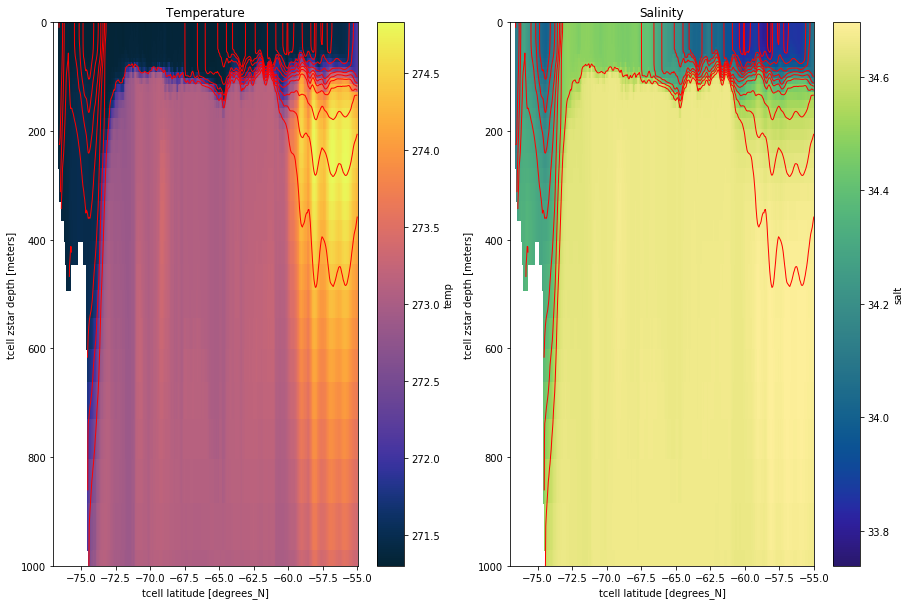

In [40]:
plt.figure(figsize=(15,10))
plt.subplot(121)
temp.plot(cmap=cm.cm.thermal)
rho.plot.contour(levels=15,colors='r',linewidths=1)
plt.ylim(ymax=1000)
plt.xlim(xmin=-77)
plt.gca().invert_yaxis()
plt.title('Temperature')
plt.subplot(122)
salt.plot(cmap=cm.cm.haline)
rho.plot.contour(levels=15,colors='r',linewidths=1)
plt.ylim(ymax=1000)
plt.xlim(xmin=-77)
plt.gca().invert_yaxis()
plt.title('Salinity')

# Weddell Sea transect (0.25°)

In [30]:
# get slice of data from 0.25° case
temp = cc.get_nc_variable('025deg_jra55v13_iaf', 'ocean.nc', 'temp',n=-1,time_units=None).mean('time')\
                        .sel(xt_ocean=-30,method='nearest').sel(yt_ocean=slice(-80,-55))
salt = cc.get_nc_variable('025deg_jra55v13_iaf', 'ocean.nc', 'salt',n=-1,time_units=None).mean('time')\
                        .sel(xt_ocean=-30,method='nearest').sel(yt_ocean=slice(-80,-55))
rho = cc.get_nc_variable('025deg_jra55v13_iaf', 'ocean.nc', 'pot_rho_0',n=-1,time_units=None).mean('time')\
                        .sel(xt_ocean=-30,method='nearest').sel(yt_ocean=slice(-80,-55))
IPython.display.clear_output()

Text(0.5,1,'Salinity')

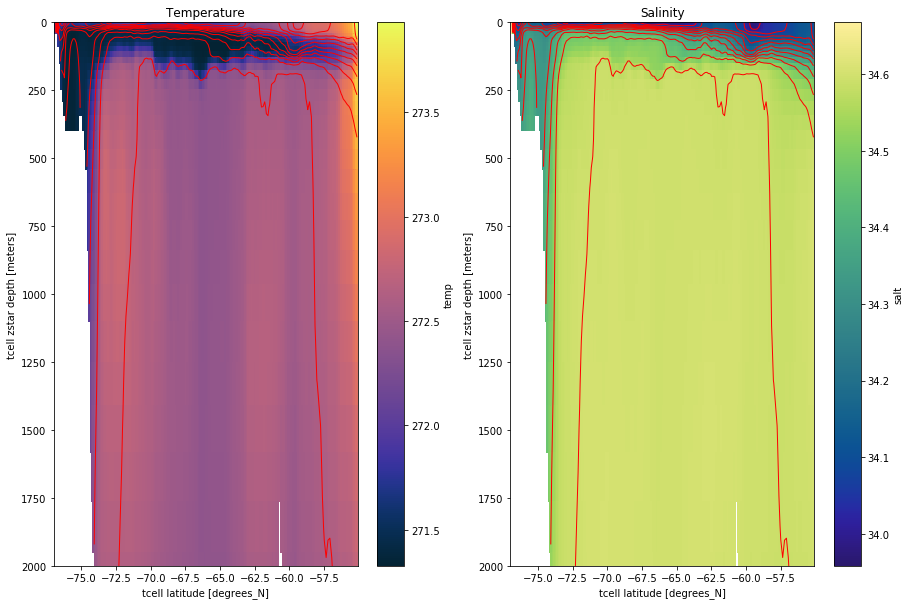

In [35]:
plt.figure(figsize=(15,10))
plt.subplot(121)
temp.plot(cmap=cm.cm.thermal)
rho.plot.contour(levels=15,colors='r',linewidths=1)
plt.ylim(ymax=2000)
plt.xlim(xmin=-77)
plt.gca().invert_yaxis()
plt.title('Temperature')
plt.subplot(122)
salt.plot(cmap=cm.cm.haline)
rho.plot.contour(levels=15,colors='r',linewidths=1)
plt.ylim(ymax=2000)
plt.xlim(xmin=-77)
plt.gca().invert_yaxis()
plt.title('Salinity')

# Ross Sea transect (0.1°)


In [37]:
# get slice of data from 0.1° case
temp_ross = cc.get_nc_variable('01deg_jra55v13_iaf', 'ocean.nc', 'temp',n=-1,time_units=None).mean('time')\
                        .sel(xt_ocean=-180,method='nearest').sel(yt_ocean=slice(-80,-55))
salt_ross = cc.get_nc_variable('01deg_jra55v13_iaf', 'ocean.nc', 'salt',n=-1,time_units=None).mean('time')\
                        .sel(xt_ocean=-180,method='nearest').sel(yt_ocean=slice(-80,-55))
rho_ross = cc.get_nc_variable('01deg_jra55v13_iaf', 'ocean.nc', 'pot_rho_0',n=-1,time_units=None).mean('time')\
                        .sel(xt_ocean=-180,method='nearest').sel(yt_ocean=slice(-80,-55))
IPython.display.clear_output()

Text(0.5,1,'Salinity')

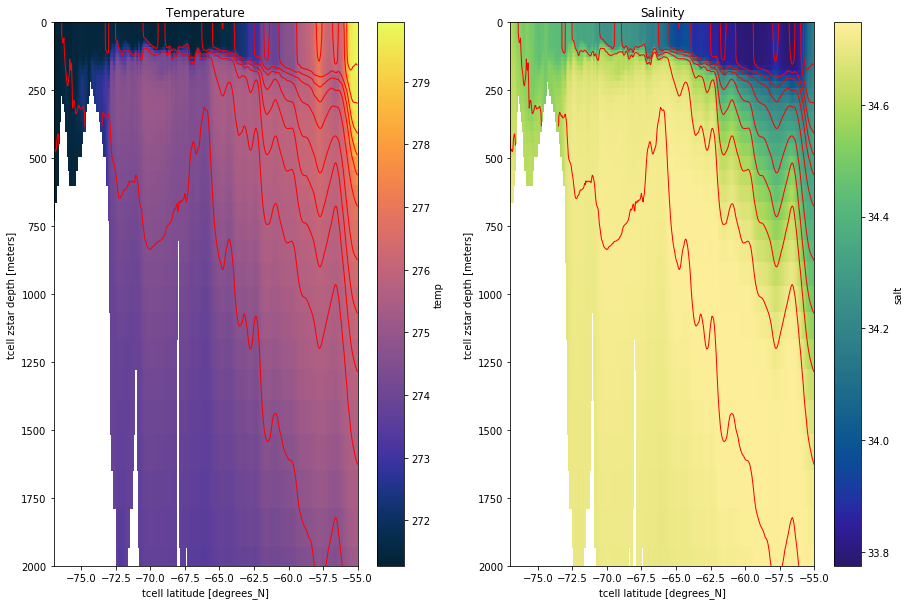

In [38]:
plt.figure(figsize=(15,10))
plt.subplot(121)
temp_ross.plot(cmap=cm.cm.thermal)
rho_ross.plot.contour(levels=15,colors='r',linewidths=1)
plt.ylim(ymax=2000)
plt.xlim(xmin=-77)
plt.gca().invert_yaxis()
plt.title('Temperature')
plt.subplot(122)
salt_ross.plot(cmap=cm.cm.haline)
rho_ross.plot.contour(levels=15,colors='r',linewidths=1)
plt.ylim(ymax=2000)
plt.xlim(xmin=-77)
plt.gca().invert_yaxis()
plt.title('Salinity')

In [28]:
# get slice of data from 0.25° case
temp_ross = cc.get_nc_variable('025deg_jra55v13_iaf', 'ocean.nc', 'temp',n=-1,time_units=None).mean('time')\
                        .sel(xt_ocean=-180,method='nearest').sel(yt_ocean=slice(-80,-55))
salt_ross = cc.get_nc_variable('025deg_jra55v13_iaf', 'ocean.nc', 'salt',n=-1,time_units=None).mean('time')\
                        .sel(xt_ocean=-180,method='nearest').sel(yt_ocean=slice(-80,-55))
rho_ross = cc.get_nc_variable('025deg_jra55v13_iaf', 'ocean.nc', 'pot_rho_0',n=-1,time_units=None).mean('time')\
                        .sel(xt_ocean=-180,method='nearest').sel(yt_ocean=slice(-80,-55))
IPython.display.clear_output()

Text(0.5,1,'Salinity')

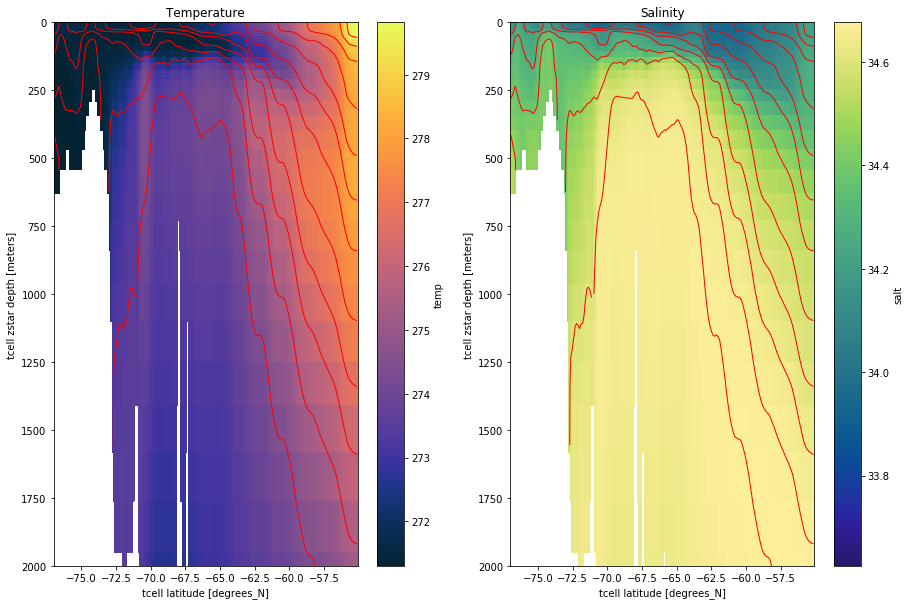

In [36]:
plt.figure(figsize=(15,10))
plt.subplot(121)
temp_ross.plot(cmap=cm.cm.thermal)
rho_ross.plot.contour(levels=15,colors='r',linewidths=1)
plt.ylim(ymax=2000)
plt.xlim(xmin=-77)
plt.gca().invert_yaxis()
plt.title('Temperature')
plt.subplot(122)
salt_ross.plot(cmap=cm.cm.haline)
rho_ross.plot.contour(levels=15,colors='r',linewidths=1)
plt.ylim(ymax=2000)
plt.xlim(xmin=-77)
plt.gca().invert_yaxis()
plt.title('Salinity')

# Mixed layer depths (0.25°)

(-81.12980012843906, -40)

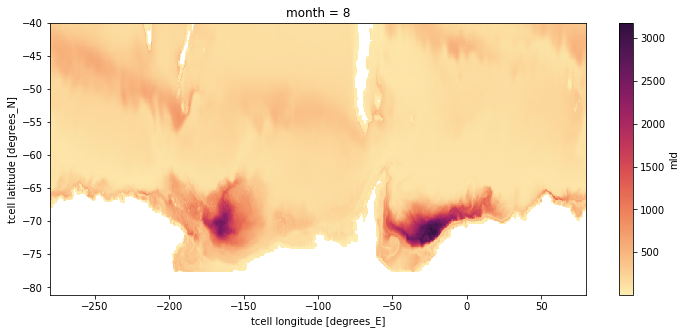

In [27]:
MLD = cc.get_nc_variable('025deg_jra55v13_iaf', 'ocean_month.nc', 'mld',time_units = None)
MLD = MLD.groupby('time.month').mean('time').sel(month=8)
IPython.display.clear_output()  

plt.figure(figsize=(12,5))
MLD.plot(cmap=cm.cm.matter)
plt.ylim(ymax=-40)

Text(0.5,1,'(b) Ross Sea MLD')

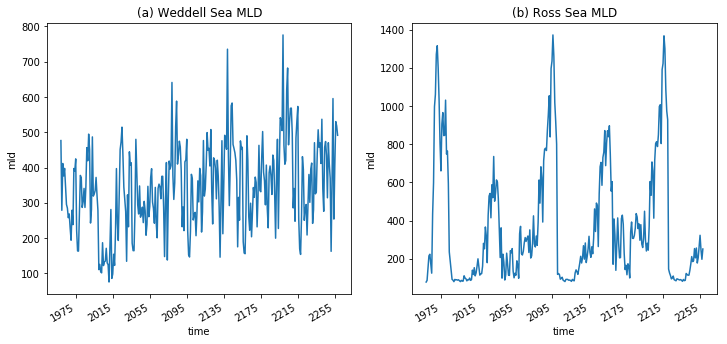

In [3]:
MLD = cc.get_nc_variable('025deg_jra55v13_iaf', 'ocean_month.nc', 'mld',time_units = None)
MLD_wed = MLD.sel(xt_ocean=slice(-50,-10)).sel(yt_ocean=slice(-75,-60)).mean('xt_ocean').mean('yt_ocean').resample(time='A').mean('time').load()
MLD_ross = MLD.sel(xt_ocean=slice(-190,-150)).sel(yt_ocean=slice(-75,-60)).mean('xt_ocean').mean('yt_ocean').resample(time='A').mean('time').load()

IPython.display.clear_output()  

plt.figure(figsize=(12,5))
plt.subplot(121)
MLD_wed.plot()
plt.title('(a) Weddell Sea MLD')
plt.subplot(122)
MLD_ross.plot()
plt.title('(b) Ross Sea MLD')

## Simulations

We will compare four different simulations, all at 0.25° with KDS50 vertical resolution:
1. **RYF**: The original 150-year RYF simulation, using 1984-85 forcing. This case had no GM parameterisation and very weak abyssal circulation. We did test GM and Redi parameterisations with the RYF case, but neither of these were suitable.
2. **IAF**: Our first IAF attempt, with a full 5 cycles (300 years). This run was infected with horrific Ross Sea polynyas, at the start of every cycle, which overwhelmed the overturning circulation and shut dowm the AMOC.
3. **GMRedi**: A case with weak Aredi and AGM. Basically, we set Aredi to scale with latitude, with a minimum value of 1m^2/s and a maximum of 200m^2/s. The AGM has the same range and also scales with latitude - but uses the baroclinic closure, so is very weak in unstratified regions (where, for example, polynyas form). This means that AGM is relatively weak in the polar regions (see plot below).
4. **GMRedi3**: Same as GMRedi, but adding an extra component of GM. (Not used)
5. **Submesoscale:** Trying submesoscale parameterisation. (Not used)

In [4]:
esub = [
 '025deg_jra55v13_ryf8485_KDS50',
 '025deg_jra55v13_iaf',
 '025deg_jra55v13_iaf_gmredi',
 #'025deg_jra55v13_iaf_gmredi3',
 #'025deg_jra55v13_iaf_submeso',
       ]

CPU times: user 1min 1s, sys: 23.8 s, total: 1min 25s
Wall time: 2min 40s


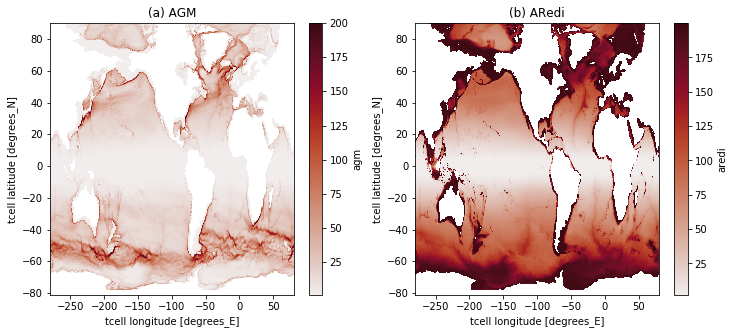

In [5]:
%%time
expt = esub[2]
AGM = cc.get_nc_variable(expt, 'ocean_month.nc', 'agm',n=-10,time_units = None)
ARedi = cc.get_nc_variable(expt, 'ocean_month.nc', 'aredi',n=-10,time_units = None)
IPython.display.clear_output()

plt.figure(figsize=(12,5))
plt.subplot(121)
AGM.mean('time').plot(cmap=cm.cm.amp)
plt.title('(a) AGM')
plt.subplot(122)
ARedi.mean('time').plot(cmap=cm.cm.amp)
plt.title('(b) ARedi')

**This plot shows** the eddy parameterisation values from the last 20 years of the GMRedi case. Note that ARedi is, in general, larger than AGM, especially in polar regions where weak baroclinicity acts to reduce the AGM parameter. This may not be optimal for the purposes of damping polynya activity??

## Drake Passage Transport

In [ ]:
%%time
results=[]
for expt in esub:
    tx = cc.get_nc_variable(expt,'ocean_month.nc','tx_trans_int_z',
                         chunks={'yt_ocean':200},time_units = None,
                         use_bag=False)
    
    tx_trans = tx.sel(xu_ocean=-69,method='nearest').sel(yt_ocean=slice(-72,-52))
    
    transport = tx_trans.sum('yt_ocean').resample(time="A").mean('time')*1.0e-9
    result = {'transport': transport,'expt': expt}
    results.append(result)
IPython.display.clear_output()    

plt.figure(figsize=(8,5))
for result in results:
    result['transport'].plot(label=result['expt'])
plt.legend()
plt.title('Drake Passage Transport')
plt.gca().autoscale()

**The large Drake Passage transport** in IAF cases is possibly related to polynya activity (but it isn't well-correlated in time, see below).

## Other timeseries

In [ ]:
variables = ['ke_tot',
             'temp_global_ave', 
             'salt_surface_ave',
             'eta_global']
cc.plots.annual_scalar(esub, variables)

# Mixed Layer Depth


In [ ]:
%%time
results=[]
for expt  in esub:
    MLD = cc.get_nc_variable(expt, 'ocean_month.nc', 'mld',time_units = None)
    MLD = MLD.groupby('time.month').mean('time').sel(month=8)
    result = {'MLD': MLD,'expt': expt}
    results.append(result)

IPython.display.clear_output()  

plt.figure(figsize=(16,12))
for i,result  in enumerate(results):
    plt.subplot(5,1,i+1)
    result['MLD'].plot(cmap=cm.cm.matter)
    plt.ylim(ymax=-30)
    if i<3:
        plt.xlabel('')
    plt.title(result['expt'])

**This plot shows** mixed layer depths in August, averaged over the entire run. Large Ross Sea polynyas occur in the IAF case, and they don't really seem to be reduced by the addition of GMRedi.

In [ ]:
%%time
results=[]
for i,expt  in enumerate(esub):
    MLD = cc.get_nc_variable(expt, 'ocean_month.nc', 'mld',time_units = None)
    MLD_wed = MLD.sel(xt_ocean=slice(-50,-10)).sel(yt_ocean=slice(-75,-60)).mean('xt_ocean').mean('yt_ocean').resample(time='A').mean('time').load()
    MLD_ross = MLD.sel(xt_ocean=slice(-190,-150)).sel(yt_ocean=slice(-75,-60)).mean('xt_ocean').mean('yt_ocean').resample(time='A').mean('time').load()
    result = {'MLD_wed': MLD_wed,'MLD_ross': MLD_ross,'expt': expt}
    results.append(result)
    
IPython.display.clear_output()  

plt.figure(figsize=(12,5))
for result in results:
    plt.subplot(121)
    result['MLD_wed'].plot(label=result['expt'])
    plt.subplot(122)
    result['MLD_ross'].plot(label=result['expt'])

plt.subplot(121)
plt.title('(a) Weddell Sea MLD')
plt.gca().autoscale()
plt.legend()

plt.subplot(122)
plt.title('(b) Ross Sea MLD')
plt.gca().autoscale()

**This plot shows** the time evolution of the Ross Sea polynyas. There is a clear cycle in the IAF cases, synchronous with the IAF cycle, showing that perhaps forcing around 1960 is pretty anomalous. On the other hand, Weddell Sea polynya activity is roughly constant over the duration of the simulation.

## Overturning Circulation

In [ ]:
def calc_psi_avg(expt, n=4):
    ## n reads in teh first n files of the timeseries
    
    
    ## Load overturning from ocean.nc file
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None}, n=n,
                          time_units=None, offset=None)
    psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
    
    ## If GM overturning is output, load that too
    varlist = cc.get_variables(expt, 'ocean.nc')
    if 'ty_trans_rho_gm' in varlist:
        GM = True
        psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                              chunks={'potrho': None}, n=n,
                              time_units=None, offset=None)
        psiGM = psiGM.mean('time').sum('grid_xt_ocean')*1.0e-9
    else:
        GM = False
        
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    if GM:
        psi_avg = psi_avg + psiGM
    
    ## This function basically splits the calculation up to save on memory:
    psi_avg = cc.compute_by_block(psi_avg)
    #psi_avg = psi_avg.compute()
    
    return psi_avg

In [ ]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):

    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.curl,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

In [ ]:
plt.figure(figsize=(12,12))
clev=np.arange(-25,25,2)

n_files = -30

results=[]
for expt in esub:
    psi_avg = calc_psi_avg(expt,n_files)
    result = {'psi_avg':psi_avg,'expt':expt}
    results.append(result)
    
IPython.display.clear_output()  


for i, result in enumerate(results):
    plt.subplot(3,2,i+1)
    p1=plot_psi(result['psi_avg'],clev)
    if i<2:
        plt.xlabel('')
    plt.title(result['expt'])

plt.savefig('overturning.png')

**This plots shows** overturning circulation over the last full cycle of the simulation, noting that the GMRedi cases has had less time to spin up. 

In [ ]:
%%time
results=[]
for expt in esub:    
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                            chunks={'potrho': None},
                            time_units = None, offset=None)
    psi_40S = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-40)*1.0e-9
    psi_40S_sum = psi_40S.cumsum('potrho') - psi_40S.sum('potrho')
    
    
    psi_26N = psi.sel(method='Nearest',grid_yu_ocean=26)\
                    .sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
    psi_26N_sum = psi_26N.cumsum('potrho') - psi_26N.sum('potrho')
    
#    varlist = cc.get_variables(expt, 'ocean.nc')
#    if 'ty_trans_rho_gm' in varlist:
#        psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
#                            chunks={'potrho': None},
#                            time_units = None, offset=None)
#        
#        psiGM_40S = psiGM.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-40)*1.0e-9
#        psi_40S_sum = psi_40S_sum + psiGM_40S
#        
#        psiGM_26N = psiGM.sel(method='Nearest',grid_yu_ocean=26)\
#                    .sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
#        psi_26N_sum = psi_26N_sum + psiGM_26N

    psi_aabw = -psi_40S_sum.sel(potrho=slice(1036,None))\
                .min('potrho').resample(time='A').mean('time')
    psi_amoc = psi_26N_sum.sel(potrho=slice(1035.5,None))\
                .max('potrho').resample(time='A').mean('time')
    
    result = {'psi_aabw':psi_aabw,'psi_amoc':psi_amoc,'expt':expt}
    results.append(result)
    
IPython.display.clear_output()  

plt.figure(figsize=(12,5))
for result in results:
    plt.subplot(121)
    result['psi_aabw'].plot(label=result['expt'])
    plt.subplot(122)
    result['psi_amoc'].plot(label=result['expt'])
    
plt.subplot(121)
plt.gca().autoscale()
plt.legend()
plt.ylabel('Overturning (Sv)')
plt.xlabel('Year')
plt.title('(a) Abyssal overturning at 40°S')

plt.subplot(122)
plt.gca().autoscale()
plt.xlabel('Year')
plt.ylabel('')
plt.title('(b) AMOC overturning at 26°N')

plt.savefig('overturning_timeseries.png')

**This plot shows** the global abyssal overturning and the Atlantic overturning at 26N. Note that the large abyssal overturning in the IAF case (polynya-driven) is weaker with GMRedi (even though polynyas are still present). The timescale of complete collapse of the AMOC in the IAF case is several IAF cycles. It's not yet clear if the same will occur with GMRedi.

## Conclusions

* Polynyas, particularly in the Ross Sea, are problematic in the IAF simulation, driving a very strong abyssal cell.
* There is a collapse in the AMOC which takes ~100 years to manifest, and which may be due to the influence of the strong abyssal overturning.
* The weak GMRedi used here didn't really help to remove the polynyas, but *does* slow down the abyssal cell. It's not yet clear how the AMOC will respond.

## Next Steps
1. Try stronger GM in polar gyres?? (started, 10 years in...)
2. Eliminate first decade from IAF??